<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# RAG with PyTorch
Estimated time needed: **60** minutes



## Introduction
As a machine learning engineer hired by a social media company, your task is determining whether songs shared on the platform are appropriate for children. Given the high costs associated with processing each song using large language models (LLMs) for content evaluation, an alternative method using retrieval-augmented generation (RAG) is proposed. RAG combines the benefits of a retriever model, which fetches relevant information (in this case, embeddings of pre-answered content appropriateness questions), and a generator model, which uses this information to predict the appropriateness of new content. This approach efficiently scales the evaluation process while ensuring that each song's content is scrutinized for child safety without the overhead of running a full LLM for each song.

![A big yellow bird puppet and a purple dinosaur puppet singing next to a rapper and a metal band singer](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/MGy9JGkmyNnnTPqNlXk2uw/The%20scene%20is%20lively%20and%20colorful.jpg)


# __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-required-libraries">Importing required libraries</a></li>
            <li><a href="#Defining-helper-functions">Defining helper functions</a></li>
        </ol>
    </li>
    <li>
        <a href="#Embeddings-using-BERT-and-PyTorch-Hub">Embeddings using BERT and PyTorch Hub</a>
        <ol>
            <li><a href="#Loading-tokenizer-and-model">Loading tokenizer and model</a>
                <ol>
                    <li><a href="#Tokenization">Tokenization</a></li>
                    <li><a href="#Text-decoding-and-verification">Text decoding and verification</a></li>
                    <li><a href="#Device-and-Convert-Tensor">Device and Convert Tensor</a></li>
                    <li><a href="#Loading-the-BERT-model">Loading the BERT model</a></li>
                    <li><a href="#Generating-aggregated-mean-embeddings-using-BERT-for-RAG">Generating aggregated mean embeddings using BERT for RAG</a></li>
                </ol>
            </li>
        </ol>
    </li>
    <li><a href="#Convert-questions-and-the-song-lyrics-into-embeddings">Convert questions and the song lyrics into embeddings</a></li>
    <li><a href="#Understanding-the-dot-product">Understanding the dot product</a></li>
    <li>
        <a href="#Exercise">Exercise</a>
        <ol>
            <li><a href="#Task-description">Task description</a></li>
        </ol>
    </li>
</ol>


---


# Objectives

After completing this lab, you will be able to:

- **Understand embedding techniques**: Learn how to generate and use embeddings from pre-trained models for natural language processing tasks.
- **Use Hugging Face Transformers with PyTorch**: Apply the transformers library to load and work with advanced NLP models like BERT in PyTorch..
- **Apply t-SNE for visualization**: Use t-SNE to visualize high-dimensional data in lower-dimensional spaces, enhancing understanding of data distribution and clustering.
- **Fine-tuning language models**: Gain practical experience in fine-tuning pretrained language models for specific tasks, enhancing model performance on targeted datasets.
- **Develop practical NLP solutions**: Implement a system that effectively uses Retriever and Generator architectures to answer queries, demonstrating an end-to-end workflow from model tuning to deployment.
- **Implement cosine similarity**: Replace dot product similarity measures with cosine similarity to improve relevance detection in response generation systems.
- **Evaluate model performance**: Assess the impact of using cosine similarity over dot product in terms of retrieval accuracy and relevance in a QA system.


---


# Setup


### Installing required libraries


For this lab, you will be using the following libraries. These libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:

***Note : After installing please ensure that you restart the kernel and execute the subsequent cells.***


In [ ]:
!pip install --user numpy
!pip install --user torch==2.2.0
!pip install --user sacremoses==0.1.1
!pip install --user torchtext
!pip install --user transformers==4.40.2
!pip install --user matplotlib==3.8.4
!pip install --user sentencepiece==0.2.0
!pip install --user scikit-learn==1.4.2

### Importing required libraries


In [1]:
from tqdm import tqdm
import numpy as np
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# You can also use this section to suppress warnings generated by your code:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Defining helper functions

The `tsne_plot` function applies t-SNE to reduce high-dimensional data to three dimensions and creates a 3D scatter plot of the results. It sets the `perplexity` to the number of data points minus one, plots each point in a unique color based on its index, and labels the axes for each t-SNE component. The visualization helps in exploring patterns in a 3D space.


In [2]:
def tsne_plot(data, plot):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42, perplexity=min(50, data.shape[0] - 1))  # Using 50 or less based on data size
    data_3d = tsne.fit_transform(data)
    
    # Plotting
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign colors for each point based on its index
    colors = plt.cm.rainbow(np.linspace(0, 1, len(data_3d)))
    for idx, point in zip(range(len(data_3d)), data_3d):
        ax.scatter(point[0], point[1], point[2], color=colors[idx], label=f'{plot} {idx+1}')
    
    # Adding labels and titles
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization of '+ plot +' Embeddings')
    plt.legend(title=plot +' Index', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Embeddings using BERT and PyTorch Hub

Use PyTorch and the Transformers library by Hugging Face to tokenize text, convert it to embeddings using BERT, and handle these embeddings with a model.

## Loading tokenizer and model 
Let's begin by loading a tokenizer and later a model, both specifically bert-base-uncased. This is done using torch.hub.load, which is a convenient way to load pre-trained models and tokenizers directly from Hugging Face's model hub.


In [3]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

The input_text variable is set as a list of tuples. 


In [4]:
# Input text to get embeddings for
input_text = [("This is an example sentence for BERT embeddings.", "How do you like it "),("There are other models")]

### Tokenization

```batch_encode_plus``` method is used for tokenizing text. It automatically handles padding and truncation to ensure uniformity in input length, which is crucial for batch processing in models like BERT.


In [5]:
input_ids = tokenizer.batch_encode_plus(input_text,add_special_tokens=True,padding=True,truncation=True)
input_ids

{'input_ids': [[101, 2023, 2003, 2019, 2742, 6251, 2005, 14324, 7861, 8270, 4667, 2015, 1012, 102, 2129, 2079, 2017, 2066, 2009, 102], [101, 2045, 2024, 2060, 4275, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

### Text decoding and verification
After tokenization, the script decodes the first tokenized input back to text to check the correctness and length of the tokenization process.


In [6]:
text=tokenizer.decode(input_ids['input_ids'][0])
print(text)
print(f"length {len(text.split())}")

[CLS] this is an example sentence for bert embeddings. [SEP] how do you like it [SEP]
length 16


In [7]:
input_ids['attention_mask']

[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]


When using the BERT tokenizer, the output includes key components that are essential for the model's processing:

```input_ids```: A list of token IDs that represent each token in BERT's vocabulary.

```token_type_ids```: Indicates which sentence each token belongs to, important for tasks involving sentence pairs.

```attention_mask```: Identifies which tokens should be focused on, differentiating real content from padding.


Special tokens:

[CLS]: Placed at the start of every input for use in classification tasks.

[SEP]: Separates sentences in dual-sentence tasks and marks the end of input sequences.


### Device and Convert Tensor
Here, you are going to convert the token IDs and attention masks into PyTorch tensors and transfers them to a computing device (DEVICE) for input into BERT. This device should be defined elsewhere in the script (typically as "cuda" for GPU or "cpu").


In [8]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

In [9]:
input_ids_tensors = torch.tensor(input_ids['input_ids']).to(DEVICE)
mask_tensors = torch.tensor(input_ids['attention_mask']).to(DEVICE)

### Loading the BERT model
Now, load the BERT model and move it to the same device as the input tensors. The model then processes these inputs to generate embeddings.


In [11]:
from transformers import BertModel
bert_model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
bert_model.to(DEVICE)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [13]:
word_embding=bert_model(input_ids_tensors,mask_tensors)

### Generating aggregated mean embeddings using BERT for RAG
Here, you'll compute aggregated mean embeddings for input sequences using the BERT model you just loaded. It processes each pair of token IDs and attention masks from the input data, extracts word embeddings for non-padded tokens, and calculates their mean. The result is a list of mean embeddings for each sequence, which is then concatenated into a single tensor. This process allows for the generation of simplified yet informative representations of the input sequences, useful for tasks like clustering, similarity search, or as input to downstream models. Each document must be under 512 tokens.


In [14]:
# Initialize a list to store the mean embeddings for each input sequence
aggregated_mean_embeddings = []

# Loop over each pair of input_ids and attention_masks
for token_ids, attention_mask in tqdm(zip(input_ids['input_ids'], input_ids['attention_mask'])):
    # Convert list of token ids and attention mask to tensors
    token_ids_tensor = torch.tensor([token_ids]).to(DEVICE)
    attention_mask_tensor = torch.tensor([attention_mask]).to(DEVICE)
    print("token_ids_tensor shape:",token_ids_tensor.shape, attention_mask_tensor.shape)  # Print the shapes of the input tensors
    with torch.no_grad():  # Disable gradient calculations for faster execution
        # Retrieve the batch of word embeddings from the BERT model
        embeddings = bert_model(token_ids_tensor, attention_mask=attention_mask_tensor)[0].squeeze(0)
        print("Word embeddings shape:", embeddings.shape)
        
        # Count and print the number of zero-padding embeddings
        num_zero_paddings = (attention_mask_tensor == 0).sum().item()
        print("Number of zero padding embeddings:", num_zero_paddings)
        
        # Create a mask for positions that are not zero-padded
        valid_embeddings_mask = attention_mask_tensor[0] != 0
        print("valid_embeddings_mask:",valid_embeddings_mask)
        
        # Filter out the embeddings corresponding to zero-padded positions
        filtered_embeddings = embeddings[valid_embeddings_mask, :]
        print("Word embeddings after zero padding embeddings removed:", filtered_embeddings.shape)
        
        # Compute the mean of the filtered embeddings
        mean_embedding = filtered_embeddings.mean(axis=0)
        print("Mean embedding shape:", mean_embedding.shape)
    
        # Append the mean embedding to the list, adding a batch dimension
        aggregated_mean_embeddings.append(mean_embedding.unsqueeze(0))

# Concatenate all mean embeddings to form a single tensor
aggregated_mean_embeddings = torch.cat(aggregated_mean_embeddings)
print('All mean embeddings shape:', aggregated_mean_embeddings.shape)

token_ids_tensor shape: torch.Size([1, 20]) torch.Size([1, 20])
Word embeddings shape: torch.Size([20, 768])
Number of zero padding embeddings: 0
valid_embeddings_mask: tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])
Word embeddings after zero padding embeddings removed: torch.Size([20, 768])
Mean embedding shape: torch.Size([768])
token_ids_tensor shape: torch.Size([1, 20]) torch.Size([1, 20])


2it [00:00,  6.77it/s]

Word embeddings shape: torch.Size([20, 768])
Number of zero padding embeddings: 14
valid_embeddings_mask: tensor([ True,  True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False])
Word embeddings after zero padding embeddings removed: torch.Size([6, 768])
Mean embedding shape: torch.Size([768])
All mean embeddings shape: torch.Size([2, 768])


The above code is converted to the function ```aggregate_embeddings``` that takes token indices and their corresponding attention masks, and uses a BERT model to convert these tokens into word embeddings. It then filters out the embeddings for zero-padded tokens and computes the mean embedding for each sequence. This helps in reducing the dimensionality of the data while retaining the most important information from the embeddings.


In [15]:
def aggregate_embeddings(input_ids, attention_masks, bert_model=bert_model):
    """
    Converts token indices and masks to word embeddings, filters out zero-padded embeddings,
    and aggregates them by computing the mean embedding for each input sequence.

    """
    mean_embeddings = []
    # Process each sequence in the batch
    print('number of inputs',len(input_ids))
    for input_id, mask in tqdm(zip(input_ids, attention_masks)):
        input_ids_tensor = torch.tensor([input_id]).to(DEVICE)
        mask_tensor = torch.tensor([mask]).to(DEVICE)

        with torch.no_grad():
            # Obtain the word embeddings from the BERT model
            word_embeddings = bert_model(input_ids_tensor, attention_mask=mask_tensor)[0].squeeze(0)

            # Filter out the embeddings at positions where the mask is zero 
            valid_embeddings_mask=mask_tensor[0] != 0 
            valid_embeddings = word_embeddings[valid_embeddings_mask,:]
            # Compute the mean of the filtered embeddings
            mean_embedding = valid_embeddings.mean(dim=0)
            mean_embeddings.append(mean_embedding.unsqueeze(0))

    # Concatenate the mean embeddings from all sequences in the batch
    aggregated_mean_embeddings = torch.cat(mean_embeddings)
    return aggregated_mean_embeddings

Let's further simplify the process with the function ```text_to_emb``` which is designed to convert a list of text strings into their corresponding embeddings using a pre-defined tokenizer and calling ```aggregate_embeddings```.


In [16]:
def text_to_emb(list_of_text,max_input=512):
    data_token_index  = tokenizer.batch_encode_plus(list_of_text, add_special_tokens=True,padding=True,truncation=True,max_length=max_input)
    question_embeddings=aggregate_embeddings(data_token_index['input_ids'], data_token_index['attention_mask'])
    return question_embeddings

# Convert questions and the song lyrics into embeddings

Let's first convert both the predefined appropriateness questions and the song lyrics into "RAG embeddings". Then, you measure the similarity between these embeddings to determine appropriateness:


In [17]:
import re
def process_song(song):
    # Remove line breaks from the song
    song_new = re.sub(r'[\n]', ' ', song)
    
    # Remove single quotes from the song
    song_new = [song_new.replace("\'", "")]
    
    return song_new

Here you can find more such sample questions.


In [18]:
song_questions = [
    "Does this song contain any violent themes, such as references to guns, killing, or physical aggression? Example: Does the song describe or promote physical violence, like fighting or shootings?",
    "Are there any explicit lyrics or bad words used in this song that might be considered offensive or inappropriate? Example: Does the song use language commonly recognized as profanity or derogatory terms?",
    "Is the overall content of this song suitable for children, considering its themes, language, and messages? Example: Are there elements in the song that could be deemed too mature or unsuitable for young listeners?",
    "Does this song explicitly mention weapons, such as guns, knives, or other similar items? Example: Are specific types of weapons described or glorified in the lyrics?",
    "Are the messages conveyed in this song positive and uplifting for children? Example: Does the song promote values like kindness, friendship, and positivity?",
    "Does this song include any sexual content, references to sexual behavior, or suggestive language? Example: Are there lyrics that explicitly or implicitly discuss sexual themes or experiences?",
    "Does this song offer any educational value, such as teaching the alphabet, basic math, or other learning content? Example: Are there educational segments in the song that could help children learn fundamental skills like the ABCs or counting?",
    "Does this song promote emotional resilience and social skills among children? Example: Does the song include themes of overcoming challenges or building friendships?"
]

Let's convert the questions to embeddings.


In [19]:
embeddings_questions=street=text_to_emb(song_questions)

number of inputs 8


8it [00:01,  6.84it/s]


Let's visualize the question embeddings through a t-SNE plot.


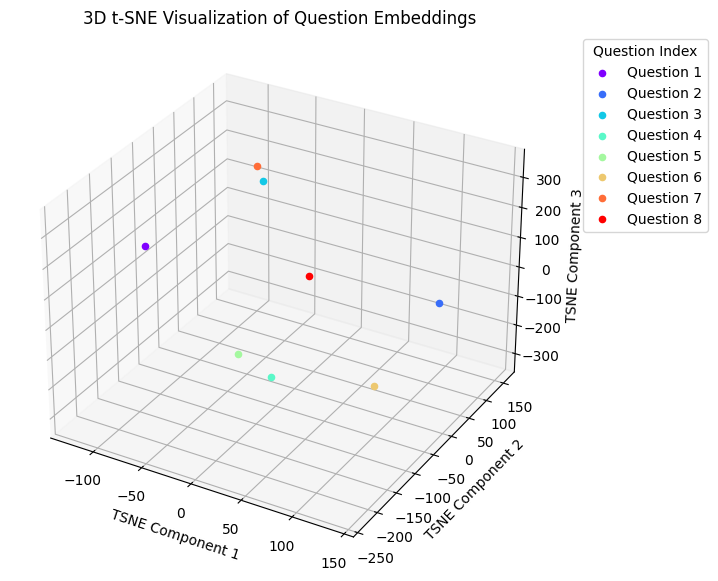

In [20]:
tsne_plot(embeddings_questions, "Question")

Let's also develop a set of responses when a song has similar attributes. 


In [21]:
yes_responses = [
    "Yes, this song contains violent themes, including references to guns, killing, or physical aggression, and is not suitable for children.",
    "Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.",
    "No, the overall content of this song is not suitable for children as it includes themes, language, and messages that are too mature or unsuitable for young listeners.",
    "Yes, this song explicitly mentions weapons, such as guns and knives, which could be disturbing or inappropriate for children’s entertainment.",
    "Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.",
    "Yes, this song includes sexual content and references to sexual behavior or suggestive language, which are inappropriate for a child-friendly environment.",
    "Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.",
    "Yes, this song promotes emotional resilience and social skills, incorporating themes about overcoming challenges and building friendships, which are essential for children's development."
]

Convert the responses to their embeddings.


In [22]:
embeddings_responses = text_to_emb(yes_responses)

number of inputs 8


8it [00:01,  7.54it/s]


Visualize the responses embeddings through a t-SNE plot.


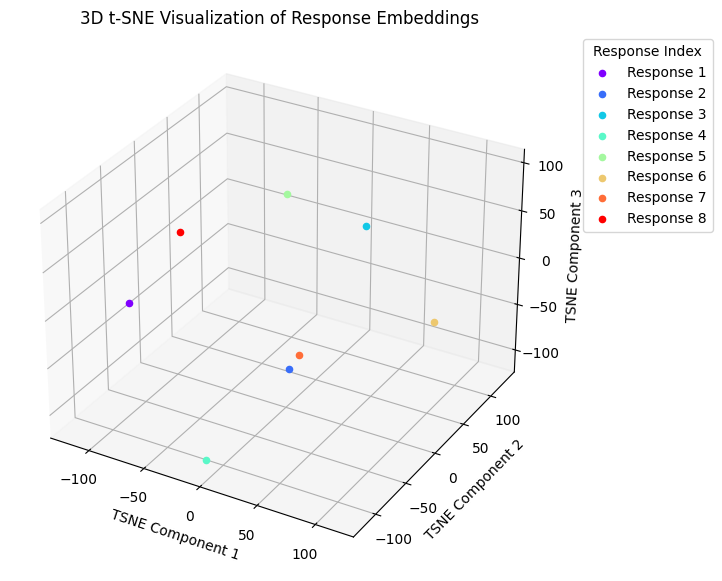

In [23]:
tsne_plot(embeddings_responses, "Response")

Consider the song [Bullet in the Head](https://en.wikipedia.org/wiki/Bullet_in_the_Head_(song)) by the activist group 'Rage Against the Machine'. The band portrays the government's use of media as a tool for population control, drawing stark comparisons between ordinary residents and Alcatraz. This song is clearly geared towards adults and is not appropriate for children due to the explicit language and violent rhetoric, which could be confusing and unsuitable for younger audiences.

<span style="color:red">Note: To browse the lyrics you can go to [Bullet in the Head](https://www.google.com/search?q=bullet+in+your+head+lyrics&rlz=1C5GCCM_en&oq=bulet+in+you+head+l&gs_lcrp=EgZjaHJvbWUqCQgBEAAYDRiABDIGCAAQRRg5MgkIARAAGA0YgAQyCQgCEC4YDRiABDIJCAMQABgNGIAEMggIBBAAGBYYHjIICAUQABgWGB4yCAgGEAAYFhgeMggIBxAAGBYYHjIICAgQABgWGB4yCAgJEAAYFhge0gEINjM1NGowajeoAgCwAgA&sourceid=chrome&ie=UTF-8) and then paste the content of the song in below cell and process it as other songs. Also, note that the song lyrics is extremely abusive</span>



In [24]:
song_rage = """
"""

After some minor preprocessing of the text, you can generate the RAG embeddings.


In [25]:
song_rage=process_song(song_rage)
embeddings_rage=text_to_emb(song_rage)
embeddings_rage.shape

number of inputs 1


1it [00:00,  8.66it/s]


torch.Size([1, 768])

Now consider the song [Can You Tell Me How to Get to Sesame Street?](https://en.wikipedia.org/wiki/Can_You_Tell_Me_How_to_Get_to_Sesame_Street%3F) — the introductory theme song of a popular children's show. Similar to previous methods, the text is processed to generate RAG embeddings.


In [26]:
sesame_street = """
Sunny day
Sweepin' the clouds away
On my way to where the air is sweet
Can you tell me how to get
How to get to Sesame Street?

Come and play
Everything's A-okay
Friendly neighbors there
That's where we meet
Can you tell me how to get
How to get to Sesame Street?

It's a magic carpet ride
Every door will open wide
To happy people like you
Happy people like
What a beautiful

Sunny day
Sweepin' the clouds away
On my way to where the air is sweet
Can you tell me how to get
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
How to get to Sesame Street?
"""

In [27]:
song_sesame_street= process_song(sesame_street)
embeddings_sesame_street=text_to_emb(song_sesame_street)

number of inputs 1


1it [00:00,  3.40it/s]


Finally, you have the song [Straight Outta Compton](https://en.wikipedia.org/wiki/Straight_Outta_Compton) — a track known for its intense themes, which nearly led to it being banned in the U.S. As with the previous examples, process the lyrics to calculate the word embeddings for a detailed analysis of its content.


<span style="color:red">Note: To browse the lyrics you can go to [Straight Outta Compton Lyrics](https://www.google.com/search?q=straight+outta+compton+song+lyrics&sca_esv=4f737f0b4de0cae7&sca_upv=1&rlz=1C5GCEM_enUS1092CA1092&sxsrf=ADLYWIIPASIwexxpdt-VqsvSF759A-iolw%3A1724787162733&ei=2inOZsW0LNSp5NoPq_XR6Qw&ved=0ahUKEwjFiZfx9JWIAxXUFFkFHat6NM0Q4dUDCA8&uact=5&oq=straight+outta+compton+song+lyrics&gs_lp=Egxnd3Mtd2l6LXNlcnAiInN0cmFpZ2h0IG91dHRhIGNvbXB0b24gc29uZyBseXJpY3MyCxAAGIAEGJECGIoFMgYQABgWGB4yBhAAGBYYHjIGEAAYFhgeMgsQABiABBiGAxiKBTILEAAYgAQYhgMYigUyCxAAGIAEGIYDGIoFMggQABiABBiiBDIIEAAYgAQYogQyCBAAGKIEGIkFSOQjUPEEWKghcAF4AZABAJgBqQGgAeAKqgEDNi42uAEDyAEA-AEBmAINoAKEC8ICChAAGLADGNYEGEfCAg0QABiABBiwAxhDGIoFwgIOEAAYsAMY5AIY1gTYAQHCAhMQLhiABBiwAxhDGMgDGIoF2AECwgIFEAAYgATCAg0QLhiABBixAxhDGIoFwgIKEAAYgAQYQxiKBcICChAuGIAEGEMYigXCAgUQLhiABMICHRAuGIAEGJcFGNwEGN4EGOAEGPQDGPEDGPUD2AEDwgIIEAAYFhgKGB6YAwCIBgGQBhK6BgYIARABGAm6BgYIAhABGAi6BgYIAxABGBSSBwM1LjigB7GKAQ&sclient=gws-wiz-serp) and then paste the content of the song in below cell and process it as other songs. Also, note that the song lyrics is extremely abusive</span>


In [28]:
straight_outta_compton_lyrics = """
"""

In [29]:
straight_outta_compton_lyrics= process_song(straight_outta_compton_lyrics)
embeddings_compton=text_to_emb(straight_outta_compton_lyrics)

number of inputs 1


1it [00:00,  8.08it/s]


Let's consider one more song.


In [30]:
my_shoe_lyrics="""Barney is a dinosaur from our imagination
And when he's tall
He's what we call a dinosaur sensation
Barney's friends are big and small
They come from lots of places
After school they meet to play
And sing with happy faces
Barney shows us lots of things
Like how to play pretend
ABC's, and 123's
And how to be a friend
Barney comes to play with us
Whenever we may need him
Barney can be your friend too
If you just make-believe him!"""

In [31]:
my_shoe_lyrics= process_song(my_shoe_lyrics)
embeddings_my_shoe=text_to_emb(my_shoe_lyrics)

number of inputs 1


1it [00:00,  4.67it/s]


Let's create a single array from the embeddings of the songs you have till now and plot it through the tsne_plot


In [32]:
songs = [song_rage, song_sesame_street, straight_outta_compton_lyrics, my_shoe_lyrics]
embeddings = [text_to_emb(song) for song in songs]
all_embeddings = np.vstack(embeddings)

number of inputs 1


1it [00:00, 10.60it/s]


number of inputs 1


1it [00:00,  3.55it/s]


number of inputs 1


1it [00:00, 14.11it/s]


number of inputs 1


1it [00:00,  4.49it/s]


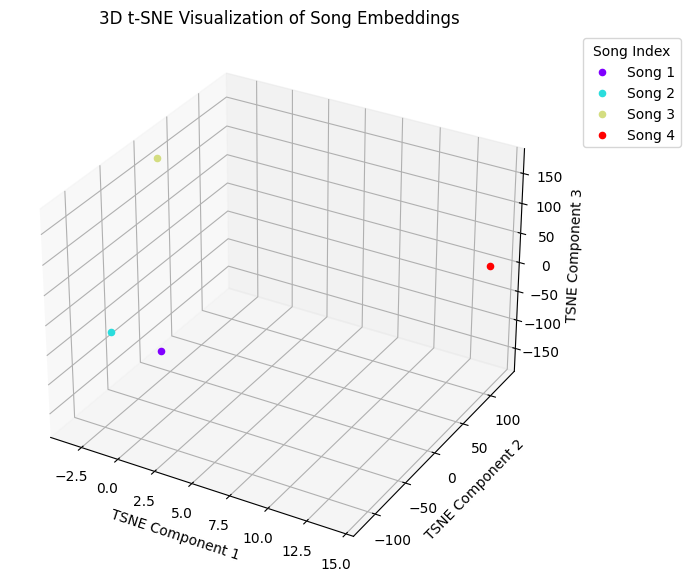

In [33]:
tsne_plot(all_embeddings, "Song")

# Understanding the dot product

The dot product of two vectors, $\mathbf{a}$ and $\mathbf{b}$, each with components $a_i$ and $b_i$, is a fundamental operation in linear algebra calculated as follows:

$\mathbf{a} \cdot \mathbf{b} = \sum_{i=1}^{n} a_i b_i$

This calculation results in a single scalar value. Geometrically, the dot product quantifies how much one vector projects onto another or how close they are to eachother.

Now, consider the matrix $A$, where each row is the RAG embeddings. In the context of matrix multiplication involving a dot product, if $A$ is a matrix and $\mathbf{b}$ is a vector, then $A\mathbf{b}$ computes the dot product of $\mathbf{b}$ with each row of $A$. In this scenario, each vector in $A$ is treated as a row vector. Here, $A$ represents `embeddings_questions`, while `embeddings_rage` is the RAG vector $\mathbf{b}$. The output is a column tensor that measures how closely each RAG vector for the questions aligns with the song.


In [34]:
dot_product = embeddings_questions@embeddings_rage.T

Reshape the tensor for processing.


In [35]:
dot_product = dot_product.reshape(-1)

You can find the questions that are closest to the song by sorting them and converting the result to a list.


In [36]:
sorted_indices = torch.argsort(dot_product,descending=True)
sorted_indices=sorted_indices.tolist()

The nearest vectors corresponding to the best response can be printed in the following manner. For simplicity, use the topmost response using ``yes_responses``.


In [37]:
for indices in  sorted_indices[0:3]:
    print(yes_responses[indices])

Yes, this song includes sexual content and references to sexual behavior or suggestive language, which are inappropriate for a child-friendly environment.
Yes, this song contains violent themes, including references to guns, killing, or physical aggression, and is not suitable for children.
Yes, this song explicitly mentions weapons, such as guns and knives, which could be disturbing or inappropriate for children’s entertainment.


Now, convert the above to a function where you only input the embeddings. 


In [38]:
def RAG_QA(embeddings_questions, embeddings, n_responses=3):
    # Calculate the dot product between the question embeddings and the provided embeddings (transpose of the second matrix for proper alignment).
    dot_product = embeddings_questions @ embeddings.T

    # Reshape the dot product results to a 1D tensor for easier processing.
    dot_product = dot_product.reshape(-1)

    # Sort the indices of the dot product results in descending order (setting descending to False should be True for typical similarity tasks).
    sorted_indices = torch.argsort(dot_product, descending=True)

    # Convert sorted indices to a list for easier iteration.
    sorted_indices = sorted_indices.tolist()

    # Print the top 'n_responses' responses from the sorted list, which correspond to the highest dot product values.
    for index in sorted_indices[:n_responses]:
        print(yes_responses[index])

Now, use the ```RAG_QA``` for the songs defined above to see the top three responses by RAG.


In [39]:
RAG_QA(embeddings_questions, embeddings_sesame_street)

Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.
Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.
Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.


In [40]:
RAG_QA(embeddings_questions, embeddings_compton)

Yes, this song includes sexual content and references to sexual behavior or suggestive language, which are inappropriate for a child-friendly environment.
Yes, this song contains violent themes, including references to guns, killing, or physical aggression, and is not suitable for children.
Yes, this song explicitly mentions weapons, such as guns and knives, which could be disturbing or inappropriate for children’s entertainment.


In [41]:
RAG_QA(embeddings_questions, embeddings_my_shoe)

Yes, this song offers significant educational value, including segments that teach the alphabet, basic math, and other learning content, making it both fun and educational for children.
Yes, this song includes explicit lyrics or bad words that might be considered offensive or inappropriate for young audiences.
Yes, the messages conveyed in this song are positive and uplifting, promoting values like kindness, friendship, and positivity, beneficial for children.


## Exercise

In many machine learning and natural language processing tasks, measuring the similarity between vectors is crucial. While the dot product is a common measure, it considers both the magnitude and direction of the vectors. In contrast, **cosine similarity** measures the cosine of the angle between two vectors, providing a similarity value that purely reflects their orientation in space regardless of their magnitude. This makes cosine similarity particularly useful in text processing where only the directionality of the vectors (i.e., the orientation of the words in the vector space) matters, not their length.

Your task is to modify the `RAG_QA()` function, which currently uses the dot product to find the most relevant responses to a given query. You will replace the dot product with cosine similarity to improve the function's ability to determine response relevance based solely on the direction of the vectors.

### Task description
1. **Modify the function**: Replace the dot product calculation in the `RAG_QA()` function with cosine similarity. Remember, cosine similarity is defined as:

   $
   \text{Cosine Similarity} = \frac{\mathbf{A} \cdot \mathbf{B}}{\|\mathbf{A}\| \|\mathbf{B}\|}
   $

   where:
   - $\mathbf{A} \cdot \mathbf{B}$ is the dot product of vectors $\mathbf{A}$ and $\mathbf{B}$,
   - $\|\mathbf{A}\|$ and $\|\mathbf{B}\|$ are the norms (or magnitudes) of vectors $\mathbf{A}$ and $\mathbf{B}$ respectively.

2. **Calculate norms**: Compute the norms of the question embeddings and the response embeddings.

3. **Compute cosine similarity**: Adjust the computation of similarity by dividing the dot product by the product of the norms of the question and response embeddings.

4. **Sort and select responses**: After computing the cosine similarities, sort the responses based on these values and select the top responses as done currently with the dot product.


In [42]:
# Write your code here


<details>
    <summary>Click here for Solution</summary>

```python
def RAG_QA_cosine(embeddings, n_responses=3):
    # Calculate the magnitudes (norms) of the question and response embeddings
    question_norms = torch.norm(embeddings_questions, dim=1, keepdim=True)
    response_norms = torch.norm(embeddings, dim=1, keepdim=True)
    
    # Calculate the dot product between the question embeddings and the provided embeddings (transpose of the second matrix for proper alignment)
    dot_product = torch.mm(embeddings_questions, embeddings.T)
    
    # Calculate cosine similarity by dividing the dot product by the product of the magnitudes
    cosine_similarity = dot_product / (question_norms * response_norms.T)
    
    # Flatten the cosine similarity tensor to a 1D tensor for easier processing
    cosine_similarity = cosine_similarity.reshape(-1)
    
    # Sort the indices of the cosine similarity results in descending order to get the indices with the highest similarity
    sorted_indices = torch.argsort(cosine_similarity, descending=True)
    
    # Convert sorted indices to a list for easier iteration
    sorted_indices = sorted_indices.tolist()
    
    # Print the top 'n_responses' responses from the sorted list, which correspond to the highest cosine similarity values
    for index in sorted_indices[:n_responses]:
        print(yes_responses[index])  # Ensure 'responses' is defined and accessible in your scope

RAG_QA_cosine(embeddings_my_shoe, n_responses=3)
```

</details>


---


## Congratulations! You have completed the lab


## Authors


[Joseph Santarcangelo](https://author.skills.network/instructors/joseph_santarcangelo) has a Ph.D. in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his Ph.D.


[Ashutosh Sagar](https://www.linkedin.com/in/ashutoshsagar/) is completing his MS in CS from Dalhousie University. He has previous experience working with Natural Language Processing and as a Data Scientist.


© Copyright IBM Corporation. All rights reserved.
